In [ ]:
#Install the modules needed for this analysis

#import pip
# !pip install numpy
# !pip install pandas
# !pip install sklearn
#!pip install matplotlib
# !pip install shap
# !pip install statsmodels.sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.5/436.5 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
#from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import export_graphviz
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import sklearn.metrics

import statsmodels.api as sm

### Loading data


In [ ]:
dat_read = pd.read_csv('imputed_dat14_re_JMF.csv')
#print(dat_read)
df = pd.DataFrame(dat_read)
print(df.shape)


NameError: name 'pd' is not defined

In [ ]:
#predictor set
X = df.iloc[:,0:67]
X.shape

(5114, 67)

In [ ]:
#outcome
y = df['EducationAttainment']
print(y)

0       12.0
1       10.0
2       10.0
3       14.0
4       14.0
        ... 
5109    16.0
5110    16.0
5111    12.0
5112    14.0
5113    12.0
Name: EducationAttainment, Length: 5114, dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=666)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4091, 67)
(1023, 67)
(4091,)
(1023,)


In [ ]:
print(X_train.index)
print(X_test.index)

Int64Index([4230, 4423,   98,  175, 4188,  743, 3894, 2626, 2964, 2082,
            ...
             563,  222, 1115, 1469, 2462, 1993,   70, 2878, 1950, 1922],
           dtype='int64', length=4091)
Int64Index([3800, 3239, 4544, 3291, 1502, 4275,  209, 2986, 4980, 2971,
            ...
            1596, 1594, 3791, 4815, 4241, 3770,  656, 3454, 4673, 1439],
           dtype='int64', length=1023)


In [ ]:
weights_read = pd.read_csv('Wave4Weights_c.csv')
df_weights = pd.DataFrame(weights_read)
print(df_weights)
weights = df_weights['GSWGT4_2']
weights_train = weights[X_train.index]
weights_test = weights[X_test.index]

           AID      GSWGT4_2
0     57101310   2936.707073
1     57103869   9388.942184
2     57109625   7918.203020
3     57111071   3850.820387
4     57113943   8559.854200
...        ...           ...
5109  99719930   2048.697141
5110  99719939   2666.193398
5111  99719970  10256.701951
5112  99719976  12675.529312
5113  99719978  15049.667047

[5114 rows x 2 columns]


## Benchmark: OLS regression

In [ ]:
ols = LinearRegression()
ols.fit(X_train, y_train, sample_weight = weights_train)
pred_test_ols= ols.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_ols))
print(sklearn.metrics.r2_score(y_test, pred_test_ols))

3.2578658930276694
0.3706573655713813


## Lasso

### Inner-loop cross-validation: tuning regularization parameter

In [ ]:
alphas_full = np.concatenate((np.linspace(0.000001, 0.000009, 9),np.linspace(0.00001, 0.00009, 9),
                            np.linspace(0.0001, 0.0009, 9), np.linspace(0.001, 0.009, 9),
                             np.linspace(0.01, 0.09, 9), np.linspace(0.1, 0.9, 9),
                             np.linspace(1, 9, 9), np.linspace(10, 90, 9), np.linspace(100, 900, 9),
                            np.linspace(1000, 9000, 9), np.linspace(10000, 90000, 9),
                              np.linspace(100000, 900000, 10)),axis=None)
alphas_full

array([1.00000000e-06, 2.00000000e-06, 3.00000000e-06, 4.00000000e-06,
       5.00000000e-06, 6.00000000e-06, 7.00000000e-06, 8.00000000e-06,
       9.00000000e-06, 1.00000000e-05, 2.00000000e-05, 3.00000000e-05,
       4.00000000e-05, 5.00000000e-05, 6.00000000e-05, 7.00000000e-05,
       8.00000000e-05, 9.00000000e-05, 1.00000000e-04, 2.00000000e-04,
       3.00000000e-04, 4.00000000e-04, 5.00000000e-04, 6.00000000e-04,
       7.00000000e-04, 8.00000000e-04, 9.00000000e-04, 1.00000000e-03,
       2.00000000e-03, 3.00000000e-03, 4.00000000e-03, 5.00000000e-03,
       6.00000000e-03, 7.00000000e-03, 8.00000000e-03, 9.00000000e-03,
       1.00000000e-02, 2.00000000e-02, 3.00000000e-02, 4.00000000e-02,
       5.00000000e-02, 6.00000000e-02, 7.00000000e-02, 8.00000000e-02,
       9.00000000e-02, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
       4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
       8.00000000e-01, 9.00000000e-01, 1.00000000e+00, 2.00000000e+00,
      

In [ ]:
model_lasso = Lasso(random_state=666)
distributions = dict(alpha=alphas_full)
clf_lasso = RandomizedSearchCV(model_lasso, distributions, n_iter=100,verbose=2,
                               scoring=('neg_mean_squared_error', 'r2'),refit= 'neg_mean_squared_error',
                               cv=5, random_state=666)
search = clf_lasso.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ........................................alpha=9e-06; total time=   0.1s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ........................................alpha=9e-06; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ......................................alpha=60000.0; total time=   0.0s
[CV] END ........................................alpha=4e-06; total time=   0.0s
[CV] END .....................................

[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END ........................................alpha=0.009; total time=   0.0s
[CV] END ........................................alpha=0.009; total time=   0.0s
[CV] END ........................................alpha=0.009; total time=   0.0s
[CV] END ........................................alpha=0.009; total time=   0.0s
[CV] END ........................................alpha=0.009; total time=   0.0s
[CV] END .........................................alpha=90.0; total time=   0.0s
[CV] END .........................................alpha=90.0; total time=   0.0s
[CV] END .........................................alpha=90.0; total time=   0.0s
[CV] END .........................................alpha=90.0; total time=   0.0s
[CV] END ...................

[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=0.6; total time=   0.0s
[CV] END ..........................................alpha=5.0; total time=   0.0s
[CV] END ..........................................alpha=5.0; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.06999999999999999; total time=   0.0s
[CV] END ..........................alpha=0.06999999999999999; total time=   0.0s
[CV] END ..........................alpha=0.06999999999999999; total time=   0.0s
[CV] END ........................alpha=5.999999999999999e-06; total time=   0.0s
[CV] END ........................alpha=5.999999999999999e-06; total time=   0.0s
[CV] END ........................alpha=5.999999999999999e-06; total time=   0.0s
[CV] END ........................alpha=5.999999999999999e-06; total time=   0.0s
[CV] END ........................alpha=5.999999999999999e-06; total time=   0.0s
[CV] END .......................................alpha=0.0009; total time=   0.0s
[CV] END .......................................alpha=0.0009; total time=   0.0s
[CV] END .......................................alpha=0.0009; total time=   0.0s
[CV] END .......................................alpha=0.0009; total time=   0.0s
[CV] END ...................

[CV] END .........................................alpha=10.0; total time=   0.0s
[CV] END .........................................alpha=10.0; total time=   0.0s
[CV] END .........................................alpha=10.0; total time=   0.0s
[CV] END .........................................alpha=10.0; total time=   0.0s
[CV] END ........................................alpha=6e-05; total time=   0.0s
[CV] END ........................................alpha=6e-05; total time=   0.0s
[CV] END ........................................alpha=6e-05; total time=   0.0s
[CV] END ........................................alpha=6e-05; total time=   0.0s
[CV] END ........................................alpha=6e-05; total time=   0.0s
[CV] END ........................................alpha=0.002; total time=   0.0s
[CV] END ........................................alpha=0.002; total time=   0.0s
[CV] END ........................................alpha=0.002; total time=   0.0s
[CV] END ...................

In [ ]:
search.best_estimator_

Lasso(alpha=0.009, random_state=666)

In [ ]:
search.best_score_

-3.3671646733477574

### Outer loop training-test

In [ ]:
lasso_final = Lasso(alpha=0.009, random_state=666)
lasso_final.fit(X_train, y_train, sample_weight = weights_train)
pred_test_lasso= lasso_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_lasso))
print(sklearn.metrics.r2_score(y_test, pred_test_lasso))

3.2261126898608103
0.3767913333861235


## Decision trees

### Inner-loop cross-validation: tuning regularization parameter

In [ ]:
max_depth_full=list(range(5,21))
print(max_depth_full)
min_samples_split_full = list(range(2,41))
print(min_samples_split_full)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [ ]:
model_dt = DecisionTreeRegressor(random_state=666)
distributions = dict(max_depth=max_depth_full, min_samples_split = min_samples_split_full)
clf_dt = RandomizedSearchCV(model_dt, distributions, n_iter=100,verbose=2,
                               scoring=('neg_mean_squared_error'),refit= 'neg_mean_squared_error',
                               cv=5, random_state=666)
search = clf_dt.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.1s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END .................max_depth=13, min_samples_split=34; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=9, min_samples_split=28; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=13; total time=   0.0s
[CV] END ..................max_depth=7, min_sa

[CV] END .................max_depth=19, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=19, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=22; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=22; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=22; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=22; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=22; total time=   0.0s
[CV] END .................max_depth=18, min_samples_split=39; total time=   0.0s
[CV] END .................max_depth=18, min_samples_split=39; total time=   0.0s
[CV] END .................max_depth=18, min_samples_split=39; total time=   0.0s
[CV] END .................ma

[CV] END ...................max_depth=6, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=6, min_samples_split=5; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=37; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=37; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=37; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=37; total time=   0.0s
[CV] END .................max_depth=10, min_samples_split=37; total time=   0.0s
[CV] END .................max_depth=20, min_samples_split=11; total time=   0.0s
[CV] END .................max_depth=20, min_samples_split=11; total time=   0.0s
[CV] END .................ma

[CV] END ..................max_depth=7, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=16; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=27; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=27; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=27; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=27; total time=   0.0s
[CV] END ..................max_depth=6, min_samples_split=27; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=33; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=33; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=33; total time=   0.0s
[CV] END ..................max_depth=7, min_samples_split=33; total time=   0.0s
[CV] END ..................m

[CV] END .................max_depth=16, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=16, min_samples_split=23; total time=   0.0s
[CV] END .................max_depth=12, min_samples_split=32; total time=   0.0s
[CV] END .................max_depth=12, min_samples_split=32; total time=   0.0s
[CV] END .................max_depth=12, min_samples_split=32; total time=   0.0s
[CV] END .................max_depth=12, min_samples_split=32; total time=   0.0s
[CV] END .................max_depth=12, min_samples_split=32; total time=   0.0s
[CV] END .................max_depth=12, min_samples_split=19; total time=   0.0s
[CV] END .................max_depth=12, min_samples_split=19; total time=   0.0s
[CV] END .................ma

In [ ]:
search.best_estimator_

DecisionTreeRegressor(max_depth=5, min_samples_split=35, random_state=666)

In [ ]:
search.best_score_

-3.9045009740634855

### Outer loop training-test

In [ ]:
dt_final = DecisionTreeRegressor(max_depth=5, min_samples_split=35, random_state=666)
dt_final.fit(X_train, y_train, sample_weight = weights_train)
pred_test_dt= dt_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_dt))
print(sklearn.metrics.r2_score(y_test, pred_test_dt))

3.656515986853543
0.2936475964459765


## Random Forest

### Inner-loop cross-validation: tuning regularization parameter

In [ ]:
n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
print(n_estimators_full)

max_depth_full=list(range(5,21))
print(max_depth_full)

min_samples_split_full = list(range(2,41)) #integer 1 for min samples split caused error
print(min_samples_split_full)

[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [ ]:
model_rf = RandomForestRegressor(random_state=666)

distributions = dict(n_estimators= n_estimators_full,
                     max_depth=max_depth_full,
                     min_samples_split = min_samples_split_full)

clf_rf = RandomizedSearchCV(model_rf, distributions,
                            n_iter=100,
                            verbose=2,
                            n_jobs=4,
                            scoring=('neg_mean_squared_error'),
                            refit= 'neg_mean_squared_error',
                            cv=5,
                            random_state=666)

search = clf_rf.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_split=8, n_estimators=500; total time=   9.1s
[CV] END max_depth=17, min_samples_split=9, n_estimators=300; total time=   7.3s
[CV] END max_depth=17, min_samples_split=9, n_estimators=300; total time=   7.5s
[CV] END max_depth=15, min_samples_split=33, n_estimators=300; total time=   5.1s
[CV] END max_depth=18, min_samples_split=16, n_estimators=1000; total time=  20.9s
[CV] END .max_depth=9, min_samples_split=10, n_estimators=50; total time=   0.9s
[CV] END .max_depth=9, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END max_depth=13, min_samples_split=33, n_estimators=50; total time=   0.8s
[CV] END max_depth=13, min_samples_split=33, n_estimators=50; total time=   1.0s
[CV] END .max_depth=19, min_samples_split=

[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_split=8, n_estimators=500; total time=   9.1s
[CV] END max_depth=17, min_samples_split=9, n_estimators=300; total time=   7.2s
[CV] END max_depth=17, min_samples_split=9, n_estimators=300; total time=   7.4s
[CV] END max_depth=15, min_samples_split=33, n_estimators=300; total time=   5.1s
[CV] END max_depth=18, min_samples_split=16, n_estimators=1000; total time=  20.9s
[CV] END .max_depth=9, min_samples_split=10, n_estimators=50; total time=   0.9s
[CV] END .max_depth=9, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END max_depth=13, min_samples_split=33, n_estimators=50; total time=   0.8s
[CV] END .max_depth=19, min_samples_split=8, n_estimators=50; total time=   1.8s
[CV] END .max_depth=19, 

[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   3.3s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_split=8, n_estimators=500; total time=   9.3s
[CV] END max_depth=17, min_samples_split=9, n_estimators=300; total time=   7.2s
[CV] END max_depth=15, min_samples_split=33, n_estimators=300; total time=   5.3s
[CV] END max_depth=18, min_samples_split=16, n_estimators=1000; total time=  20.8s
[CV] END max_depth=18, min_samples_split=16, n_estimators=1000; total time=  21.8s
[CV] END max_depth=13, min_samples_split=4, n_estimators=900; total time=  20.9s
[CV] END max_depth=20, min_samples_split=11, n_estimators=700; total time=  16.5s
[CV] END max_depth=15, min_samples_split=37, n_estimators=700; total time=  14.8s
[CV] END max_depth=15, min_samples_split=37, n_estimators=700; total time=  13.0s
[CV] END max_depth

[CV] END max_depth=14, min_samples_split=14, n_estimators=10; total time=   0.2s
[CV] END max_depth=13, min_samples_split=32, n_estimators=200; total time=   3.3s
[CV] END max_depth=10, min_samples_split=8, n_estimators=500; total time=   9.1s
[CV] END max_depth=10, min_samples_split=8, n_estimators=500; total time=   9.2s
[CV] END max_depth=15, min_samples_split=33, n_estimators=300; total time=   5.5s
[CV] END max_depth=15, min_samples_split=33, n_estimators=300; total time=   5.2s
[CV] END max_depth=18, min_samples_split=16, n_estimators=1000; total time=  21.0s
[CV] END .max_depth=9, min_samples_split=10, n_estimators=50; total time=   0.9s
[CV] END max_depth=13, min_samples_split=33, n_estimators=50; total time=   0.8s
[CV] END max_depth=13, min_samples_split=33, n_estimators=50; total time=   0.9s
[CV] END .max_depth=19, min_samples_split=8, n_estimators=50; total time=   1.9s
[CV] END .max_depth=19, min_samples_split=8, n_estimators=50; total time=   1.3s
[CV] END .max_depth=6, 

In [ ]:
search.best_estimator_

RandomForestRegressor(max_depth=18, min_samples_split=12, n_estimators=1000,
                      random_state=666)

In [ ]:
search.best_score_

-3.4084238960192224

### Outer loop training-test

In [ ]:
rf_final = RandomForestRegressor(max_depth=18, min_samples_split=12, n_estimators=1000,
                      random_state=666)
rf_final.fit(X_train, y_train, sample_weight = weights_train)

pred_test_rf= rf_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_rf))
print(sklearn.metrics.r2_score(y_test, pred_test_rf))

3.198787601455105
0.3820698941642222


## XGBoost

### Inner-loop cross-validation: tuning regularization parameter

In [ ]:
learning_rate_full = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
print(learning_rate_full)
n_estimators_full=[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
print(n_estimators_full)
max_depth_full=list(range(5,21))
print(max_depth_full)

[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
[10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [ ]:
model_xgb = GradientBoostingRegressor(random_state=666)
distributions = dict(n_estimators= n_estimators_full,
                     max_depth=max_depth_full, learning_rate = learning_rate_full)
clf_xgb = RandomizedSearchCV(model_xgb, distributions, n_iter=100,verbose=2,n_jobs=4,
                               scoring=('neg_mean_squared_error'),refit= 'neg_mean_squared_error',
                               cv=5, random_state=666)
search = clf_xgb.fit(X_train, y_train, sample_weight = weights_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  28.6s
[CV] END learning_rate=0.005, max_depth=15, n_estimators=500; total time=  22.9s
[CV] END learning_rate=0.005, max_depth=15, n_estimators=500; total time=  24.3s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=200; total time=   9.0s
[CV] END ....learning_rate=1, max_depth=13, n_estimators=200; total time=   1.3s
[CV] END .learning_rate=0.005, max_depth=8, n_estimators=100; total time=   2.2s
[CV] END .learning_rate=0.005, max_depth=8, n_estimators=100; total time=   2.3s
[CV] END ..learning_rate=0.05, max_depth=13, n_estimators=50; total time=   2.3s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=300; total time=  12.8s
[CV] END ..learning_rate=0.05, max_depth=12, n_estimators=50; total time=   2.0s
[CV] END ..learning_rate=0.1, max_depth=16, n_

[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  28.0s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  28.3s
[CV] END ..learning_rate=0.5, max_depth=14, n_estimators=200; total time=   2.5s
[CV] END ..learning_rate=0.5, max_depth=14, n_estimators=200; total time=   3.3s
[CV] END ....learning_rate=1, max_depth=16, n_estimators=100; total time=   0.9s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=200; total time=  10.2s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=200; total time=   9.1s
[CV] END ....learning_rate=1, max_depth=10, n_estimators=700; total time=   2.6s
[CV] END ....learning_rate=1, max_depth=13, n_estimators=200; total time=   1.3s
[CV] END .learning_rate=0.005, max_depth=8, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.05, max_depth=13, n_estimators=50; total time=   2.0s
[CV] END ..learning_rate=0.0

[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.8s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  29.0s
[CV] END learning_rate=0.005, max_depth=15, n_estimators=500; total time=  23.0s
[CV] END learning_rate=0.005, max_depth=15, n_estimators=500; total time=  24.2s
[CV] END ....learning_rate=1, max_depth=10, n_estimators=700; total time=   2.7s
[CV] END ....learning_rate=1, max_depth=10, n_estimators=700; total time=   2.6s
[CV] END ....learning_rate=1, max_depth=10, n_estimators=700; total time=   2.5s
[CV] END ....learning_rate=1, max_depth=13, n_estimators=200; total time=   1.3s
[CV] END ....learning_rate=1, max_depth=13, n_estimators=200; total time=   1.3s
[CV] END .learning_rate=0.005, max_depth=8, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.05, max_depth=13, n_estimators=50; total time=   2.0s
[CV] END learning_rate=0.001, max_depth=12, n_estimators=300; total time=  12.8s
[CV] END learning_rate=0.001

[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   0.8s
[CV] END ....learning_rate=1, max_depth=18, n_estimators=600; total time=   1.0s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=600; total time=  28.3s
[CV] END learning_rate=0.005, max_depth=15, n_estimators=500; total time=  22.9s
[CV] END ..learning_rate=0.5, max_depth=14, n_estimators=200; total time=   2.6s
[CV] END ..learning_rate=0.5, max_depth=14, n_estimators=200; total time=   2.4s
[CV] END ..learning_rate=0.5, max_depth=14, n_estimators=200; total time=   2.7s
[CV] END ....learning_rate=1, max_depth=16, n_estimators=100; total time=   1.0s
[CV] END ....learning_rate=1, max_depth=16, n_estimators=100; total time=   1.1s
[CV] END ....learning_rate=1, max_depth=16, n_estimators=100; total time=   1.1s
[CV] END ....learning_rate=1, max_depth=16, n_estimators=100; total time=   1.0s
[CV] END .learning_rate=0.01, max_depth=18, n_estimators=200; total time=  10.2s
[CV] END .learning_rate=0.01

In [ ]:
search.best_estimator_

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=666)

In [ ]:
search.cv_results_ #200, 5, leaarning_rate = 0.1

{'mean_fit_time': array([ 0.87685094, 28.33015962, 23.36667624,  2.69256806,  1.01199102,
         9.44221301,  2.57658715,  1.32368827,  2.23506594,  2.11959143,
        12.44708028,  1.99339328,  9.55909667,  8.83544917,  0.58817754,
        12.62985253, 11.66297846,  1.27243428,  2.86003518,  8.62206163,
        26.53220091,  6.28125043, 33.83439765,  7.67482877, 10.40379338,
        10.95075188, 20.54251075,  2.01056743, 16.16993608, 32.4220098 ,
         2.02273364,  7.93669138,  1.42670836,  5.03478312,  8.21600766,
        17.67507505,  3.82685308,  9.68737812,  1.13392901, 17.85943699,
         4.88347001, 40.32628555,  0.4338316 ,  0.80555177,  4.69793386,
        14.95125446,  3.48275743,  3.26733251,  8.86583805,  0.43087239,
         7.72826924, 23.8806901 , 21.75501738,  7.99600925, 26.72373719,
         5.08393254,  8.65148373, 23.08838449, 19.77213659,  9.89453225,
        16.235851  ,  0.19356036, 36.02290668,  7.96908855, 21.69256172,
        10.71730814,  2.7215632 , 

In [ ]:
search.best_score_

-3.446065831264135

### Outer loop training-test

In [ ]:
xgb_final = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=200,
                      random_state=666)
xgb_final.fit(X_train, y_train, sample_weight = weights_train)
pred_test_xgb= xgb_final.predict(X_test)
print(sklearn.metrics.mean_squared_error(y_test,pred_test_xgb))
print(sklearn.metrics.r2_score(y_test, pred_test_xgb))

3.4181304567238713
0.33969804249489133


### RF is the best model

## SHAP interpretations

In [ ]:
import shap

In [ ]:
shap_values = shap.TreeExplainer(rf_final).shap_values(X_train)

In [ ]:
shap_values

array([[ 2.84430903e-04, -3.86449808e-04,  1.03203038e-02, ...,
         3.81358891e-03,  1.45772660e-03,  1.46929116e-03],
       [ 2.36728406e-04,  1.36748712e-04,  1.25686025e-02, ...,
         9.26780584e-04,  2.96676332e-03,  4.08436923e-03],
       [ 5.90516907e-04, -8.37694318e-05, -2.30301955e-02, ...,
         8.84332217e-03, -8.04920125e-04,  1.04554663e-02],
       ...,
       [ 1.94934728e-04, -4.65368718e-05, -2.67484214e-02, ...,
         5.34702899e-03,  1.08686789e-03,  4.02975677e-03],
       [ 2.96002501e-04, -3.91401694e-05,  1.42757280e-02, ...,
         3.95730260e-03,  2.62066059e-03,  8.07612722e-03],
       [ 3.00183363e-04, -1.95537534e-04,  1.19710604e-02, ...,
         4.97324417e-03,  1.23354407e-03,  5.20459388e-05]])

In [ ]:
explainer_c = shap.TreeExplainer(rf_final, X_train)
shap_values_c = explainer_c(X_train) #get the correct format of shap values for the scatter plot

100%|===================| 4088/4091 [17:56<00:00]        

In [ ]:
shap_interaction_values = shap.TreeExplainer(rf_final).shap_interaction_values(X_train)

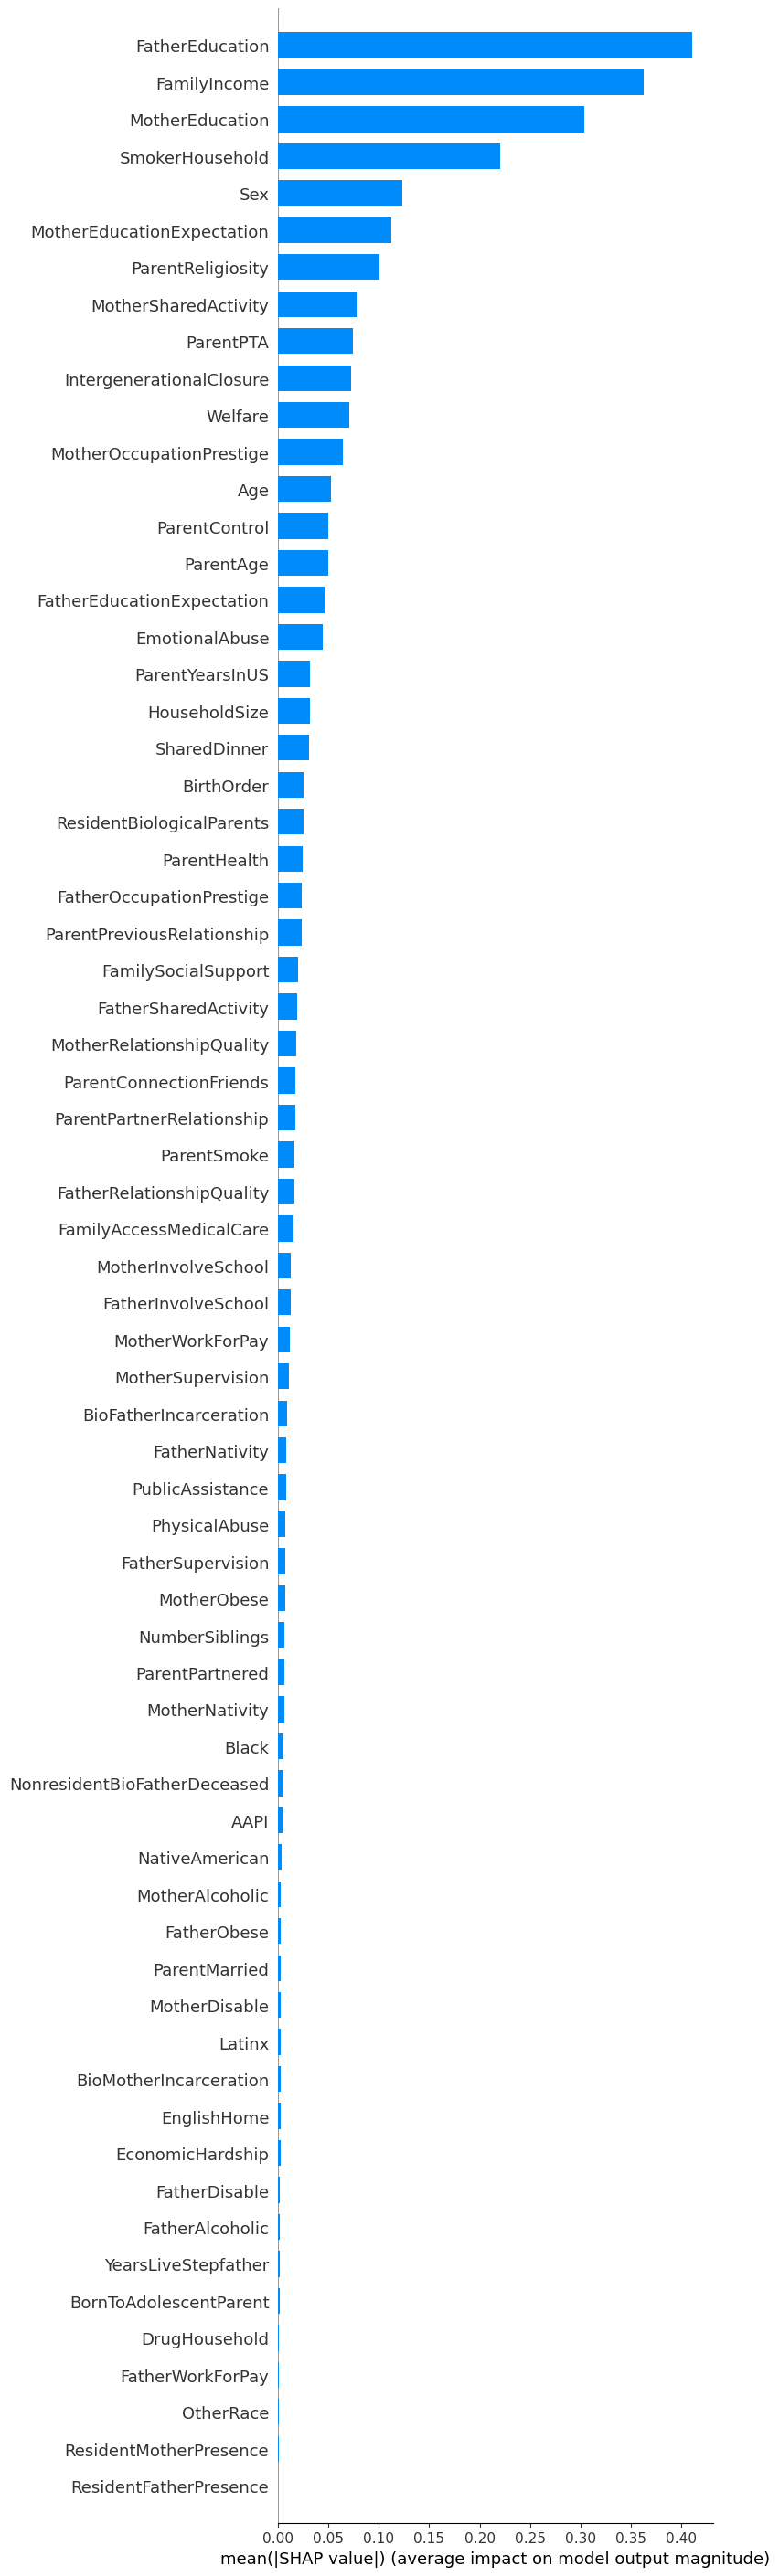

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=70)

### recursive feature elimination

In [ ]:
#weighted 5-fold cross-validation
def cross_val_scores_weighted(model, X_train, y_train, weights, cv=5,
                              metrics=[sklearn.metrics.mean_squared_error, sklearn.metrics.r2_score]):
    X_train_re = X_train.reset_index(drop=True)
    y_train_re = y_train.reset_index(drop=True)
    weights_train_re = weights_train.reset_index(drop=True)
    kf = KFold(n_splits=cv, random_state = 666, shuffle= True)
    kf.get_n_splits(X_train, y_train)
    scores = [[] for metric in metrics]
    j=1
    for tune_index, eval_index in kf.split(X_train, y_train):
        print(j)
        model_clone = sklearn.base.clone(model)
        X_tune, X_eval = X_train_re.iloc[tune_index,:], X_train_re.iloc[eval_index,:]
        y_tune, y_eval = y_train_re[tune_index], y_train_re[eval_index]
        weights_tune, weights_eval = weights_train_re[tune_index], weights_train_re[eval_index]
        #print(weights[train_index], weights[test_index])
        model_clone.fit(X_tune,y_tune,sample_weight=weights_tune)
        y_pred = model_clone.predict(X_eval)
        for i, metric in enumerate(metrics):
            score = metric(y_eval, y_pred, sample_weight = weights_eval)
            scores[i].append(score)
        j=j+1
    return scores

In [ ]:
shap_values.shape

(4091, 67)

In [ ]:
shap_absmean=np.mean(np.abs(shap_values),0)

In [ ]:
shap_absmean

array([7.34577546e-04, 2.88017023e-04, 2.51596867e-02, 2.70926111e-03,
       3.12546081e-02, 6.39075852e-03, 2.55973526e-02, 4.96967130e-02,
       3.03354526e-01, 4.11085040e-01, 6.46747615e-02, 2.38594157e-02,
       1.13568047e-02, 1.10583280e-03, 3.62896544e-01, 7.80150580e-03,
       7.10874329e-02, 2.34194241e-03, 2.00567774e-02, 3.04218099e-02,
       7.24468086e-02, 1.71281124e-02, 1.79763278e-02, 1.60317500e-02,
       7.88865870e-02, 1.89634098e-02, 6.27552632e-03, 1.67055461e-02,
       5.00611070e-02, 1.06852210e-02, 7.23571036e-03, 1.27761336e-02,
       1.24874842e-02, 7.44742991e-02, 1.11996108e-01, 4.62699777e-02,
       6.16008695e-03, 8.21944178e-03, 3.13452670e-02, 1.00474388e-01,
       2.40954098e-03, 2.41814276e-02, 1.66225611e-02, 2.80796379e-03,
       1.85052793e-03, 6.89146858e-03, 2.78874454e-03, 2.67645580e-03,
       2.13439131e-03, 2.20646907e-01, 1.17747426e-03, 1.51555137e-02,
       2.38118803e-02, 5.07318512e-03, 1.73171332e-03, 1.65046934e-03,
      

In [ ]:
feature_names = X_train.columns.values.tolist()
feature_names

NameError: name 'X_train' is not defined

In [ ]:
X_rfe = X_train
feature_names = X_train.columns.values.tolist()
mses = []
r2s=[]
feature_eliminate = []
imps_all=shap_absmean.tolist()
while len(feature_names)>0:
    scores = cross_val_scores_weighted(rf_final, X_rfe, y_train, weights_train)
    mse_avg=np.mean(scores[0])
    r2_avg=np.mean(scores[1])
    print('mse', mse_avg)
    mses.append(mse_avg)
    print('r2', r2_avg)
    r2s.append(r2_avg)
    least_imp_ind = np.argmin(imps_all)
    print(feature_names[least_imp_ind], least_imp_ind)
    X_rfe = X_rfe.drop(feature_names[least_imp_ind], axis=1)
    feature_eliminate.append(feature_names[least_imp_ind])
    feature_names.pop(least_imp_ind)
    imps_all.pop(least_imp_ind)
    print(X_rfe.shape)

1
2
3
4
5
mse 3.418205450267487
r2 0.32805221233915755
ResidentFatherPresence 1
(4091, 66)
1
2
3
4
5
mse 3.4184793795416604
r2 0.32800271024537997
ResidentMotherPresence 0
(4091, 65)
1
2
3
4
5
mse 3.417565029391471
r2 0.3281772135200178
OtherRace 60
(4091, 64)
1
2
3
4
5
mse 3.417935275503934
r2 0.3280980619277582
FatherWorkForPay 11
(4091, 63)
1
2
3
4
5
mse 3.416277552377327
r2 0.32843681515093237
DrugHousehold 47
(4091, 62)
1
2
3
4
5
mse 3.415665757011001
r2 0.3285517823951934
BornToAdolescentParent 51
(4091, 61)
1
2
3
4
5
mse 3.4168224657862867
r2 0.32830041809148564
YearsLiveStepfather 50
(4091, 60)
1
2
3
4
5
mse 3.415294906700396
r2 0.328590336505837
FatherAlcoholic 41
(4091, 59)
1
2
3
4
5
mse 3.4130041309834724
r2 0.32904590102808434
FatherDisable 44
(4091, 58)
1
2
3
4
5
mse 3.4120945382554195
r2 0.32925267848896744
EconomicHardship 14
(4091, 57)
1
2
3
4
5
mse 3.41275524023616
r2 0.3291677340198752
EnglishHome 36
(4091, 56)
1
2
3
4
5
mse 3.412876281333478
r2 0.32916016503144885
Bi

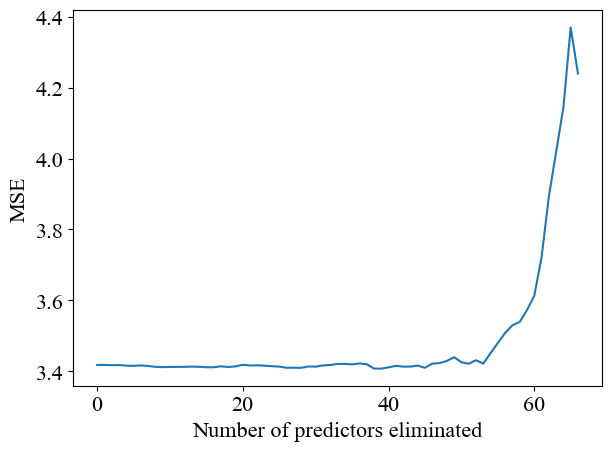

In [ ]:
#plot the RFE curve
eli = range(67)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(eli, mses)
plt.ylabel('MSE')
plt.xlabel('Number of predictors eliminated')
plt.tight_layout()
plt.savefig('mse_rfe', dpi=1000)
plt.show()

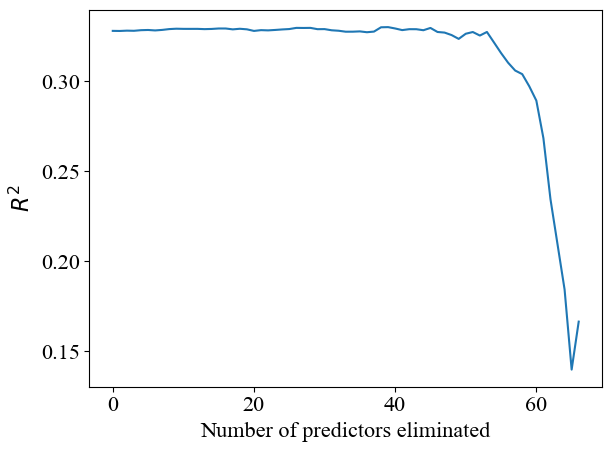

In [ ]:
eli = range(67)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(eli, r2s)
plt.ylabel('$R^{2}$')
plt.xlabel('Number of predictors eliminated')
plt.tight_layout()
plt.savefig('r2_rfe', dpi=1000)
plt.show()

In [ ]:
mses

[3.418205450267487,
 3.4184793795416604,
 3.417565029391471,
 3.417935275503934,
 3.416277552377327,
 3.415665757011001,
 3.4168224657862867,
 3.415294906700396,
 3.4130041309834724,
 3.4120945382554195,
 3.41275524023616,
 3.412876281333478,
 3.412930280261508,
 3.413602504930066,
 3.4130832111582436,
 3.411792609292417,
 3.411762025896671,
 3.414342496564308,
 3.412640359743567,
 3.4142201362121,
 3.418813612244371,
 3.4166957329929795,
 3.417313234264386,
 3.4160674798662227,
 3.4147188000360607,
 3.4136338200151983,
 3.4103548453422925,
 3.4105372223114694,
 3.4101836317608205,
 3.413925654939708,
 3.4135806417690695,
 3.416826188119218,
 3.4181813538258283,
 3.4211127688787237,
 3.421046429321199,
 3.419979585033322,
 3.42251293760435,
 3.4204336305854413,
 3.4081070964708644,
 3.4078129316652914,
 3.4115734042480903,
 3.4158726107642137,
 3.4134813552228045,
 3.413741056397079,
 3.4164902275020013,
 3.410232738244491,
 3.4220020018209327,
 3.4234909616510683,
 3.429405787721285,


In [ ]:
mses.index(3.4222179171778633) #53; this is the last low MSE


53

In [ ]:
r2s

[0.32805221233915755,
 0.32800271024537997,
 0.3281772135200178,
 0.3280980619277582,
 0.32843681515093237,
 0.3285517823951934,
 0.32830041809148564,
 0.328590336505837,
 0.32904590102808434,
 0.32925267848896744,
 0.3291677340198752,
 0.32916016503144885,
 0.32916994078086326,
 0.3290227444541626,
 0.3291240275937309,
 0.32937619734828055,
 0.329368556526176,
 0.32889136867442603,
 0.32922073791867745,
 0.3289150589766126,
 0.32802761647768336,
 0.3284608379459226,
 0.32832789335048485,
 0.32856569552945586,
 0.32884681977968416,
 0.32906475322461015,
 0.32971388743593477,
 0.3296694415760938,
 0.32971443612129125,
 0.32899727171154064,
 0.3290345059080838,
 0.328384039955326,
 0.32812386123760773,
 0.32758909667494757,
 0.3276049682479095,
 0.3277702529949148,
 0.32729917085839694,
 0.32765702513911554,
 0.33004635652760667,
 0.33013736503772984,
 0.32938287833622737,
 0.32848409567947756,
 0.3289914436432399,
 0.32897645709484913,
 0.32841364997281025,
 0.32968407948296996,
 0.3274

In [ ]:
r2s[53]

0.3274470971183995

In [ ]:
feature_eliminate[:52] #this is all the features eliminated up till the last low MSE

['ResidentFatherPresence',
 'ResidentMotherPresence',
 'OtherRace',
 'FatherWorkForPay',
 'DrugHousehold',
 'BornToAdolescentParent',
 'YearsLiveStepfather',
 'FatherAlcoholic',
 'FatherDisable',
 'EconomicHardship',
 'EnglishHome',
 'BioMotherIncarceration',
 'Latinx',
 'MotherDisable',
 'ParentMarried',
 'FatherObese',
 'MotherAlcoholic',
 'NativeAmerican',
 'AAPI',
 'NonresidentBioFatherDeceased',
 'Black',
 'MotherNativity',
 'ParentPartnered',
 'NumberSiblings',
 'MotherObese',
 'FatherSupervision',
 'PhysicalAbuse',
 'PublicAssistance',
 'FatherNativity',
 'BioFatherIncarceration',
 'MotherSupervision',
 'MotherWorkForPay',
 'FatherInvolveSchool',
 'MotherInvolveSchool',
 'FamilyAccessMedicalCare',
 'FatherRelationshipQuality',
 'ParentSmoke',
 'ParentPartnerRelationship',
 'ParentConnectionFriends',
 'MotherRelationshipQuality',
 'FatherSharedActivity',
 'FamilySocialSupport',
 'ParentPreviousRelationship',
 'FatherOccupationPrestige',
 'ParentHealth',
 'ResidentBiologicalParent

In [ ]:
feature_eliminate[53:] #these are the key predictors

['ParentControl',
 'Age',
 'MotherOccupationPrestige',
 'Welfare',
 'IntergenerationalClosure',
 'ParentPTA',
 'MotherSharedActivity',
 'ParentReligiosity',
 'MotherEducationExpectation',
 'Sex',
 'SmokerHousehold',
 'MotherEducation',
 'FamilyIncome',
 'FatherEducation']

In [ ]:
len(feature_eliminate[53:] )

14

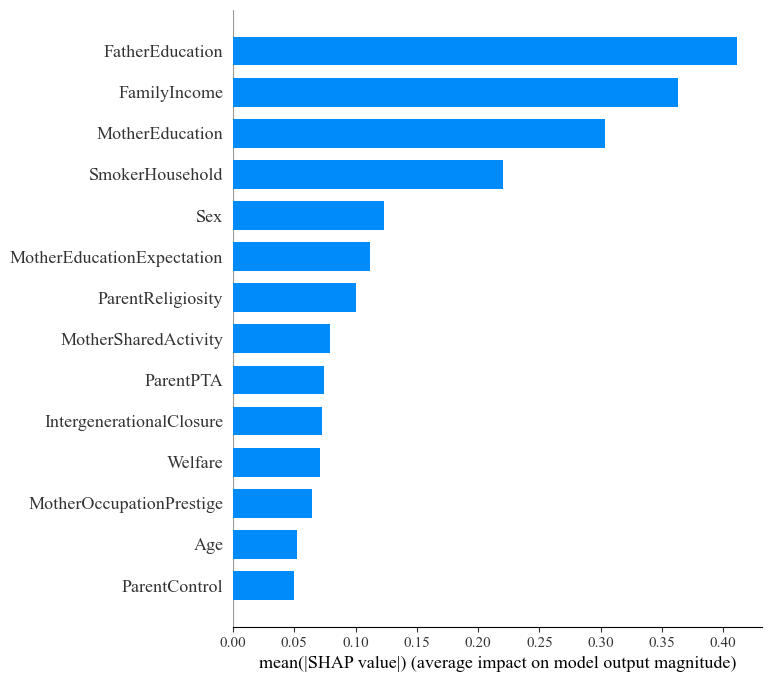

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=14)

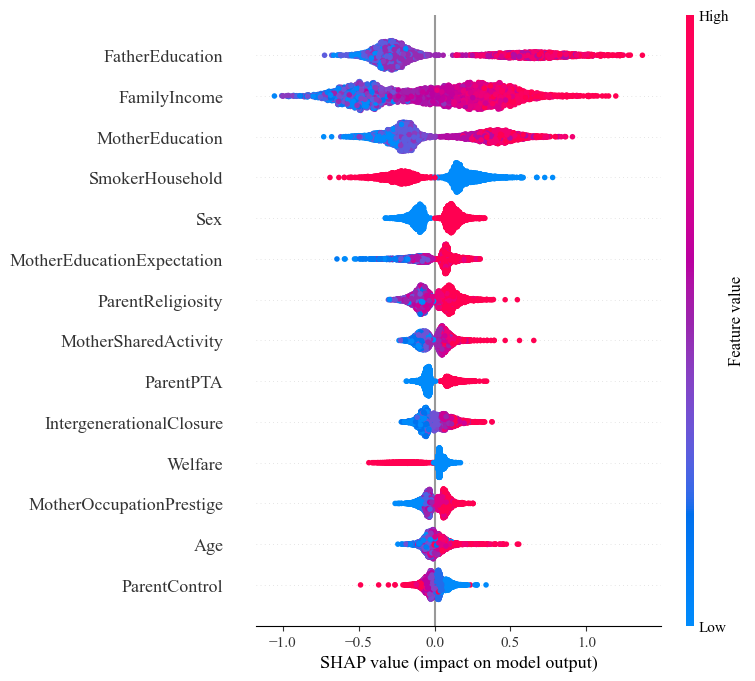

In [ ]:
shap.summary_plot(shap_values, X_train, max_display=14)

Red on the right: positive relation; red on the left: negative relation

In [ ]:
#define a function for SHAP scatter plot with regression line
def scatter_regression(feature):
    y_sv=shap_values_c[:,feature].values
    lowess = sm.nonparametric.lowess(y_sv, X_train[feature], frac=.3)
    _,ax = plt.subplots()
    ax.plot(*list(zip(*lowess)), color="black", )
    shap.plots.scatter(shap_values_c[:,feature], ax=ax)

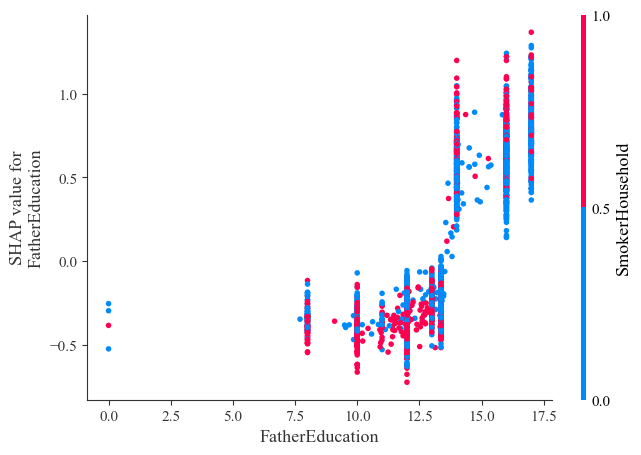

In [ ]:
shap.dependence_plot("FatherEducation", shap_values, X_train)

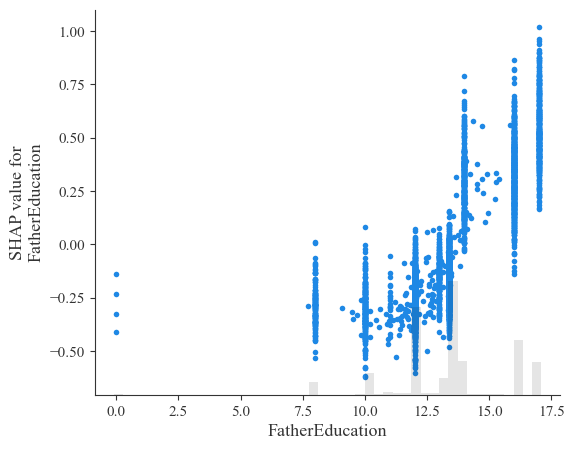

In [ ]:
shap.plots.scatter(shap_values_c[:,"FatherEducation"])

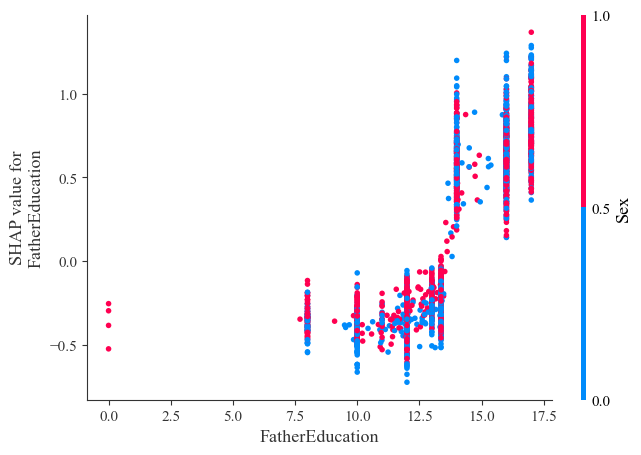

In [ ]:
shap.dependence_plot("FatherEducation", shap_values, X_train, interaction_index='Sex')

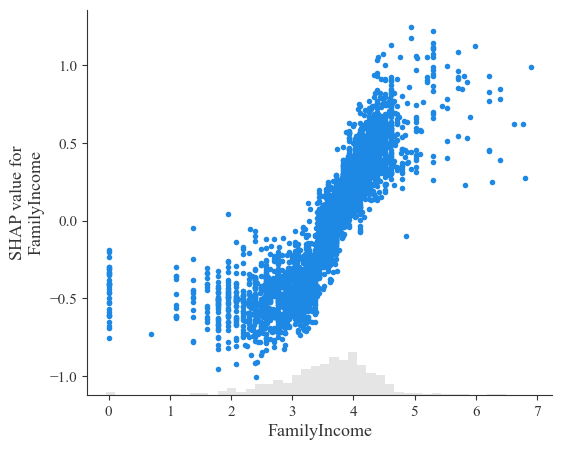

In [ ]:
shap.plots.scatter(shap_values_c[:,"FamilyIncome"])

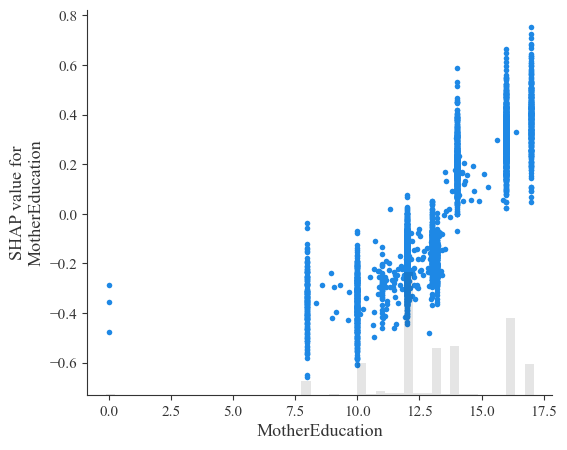

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherEducation"])

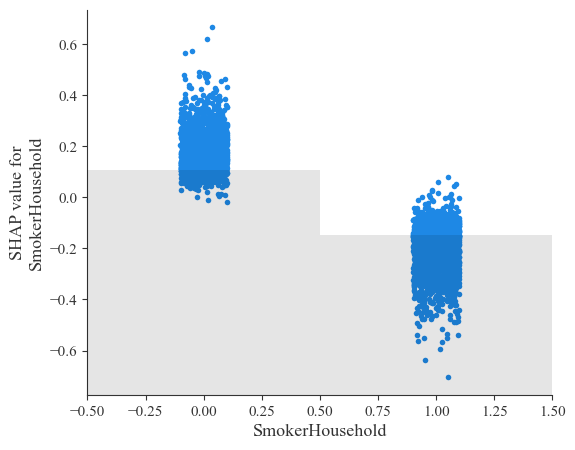

In [ ]:
shap.plots.scatter(shap_values_c[:,"SmokerHousehold"])

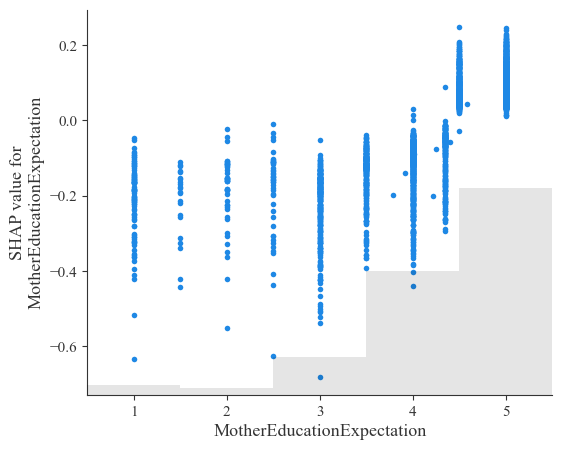

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherEducationExpectation"])

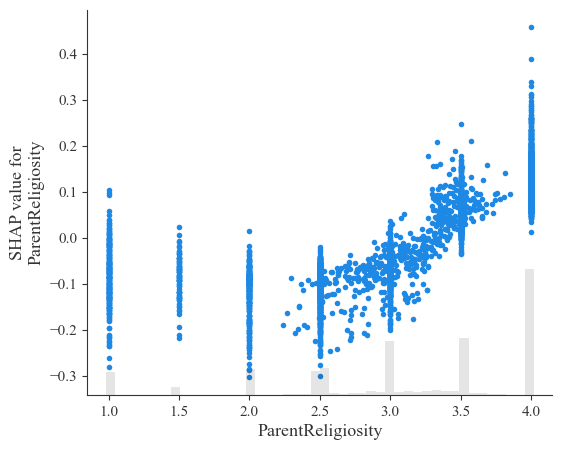

In [ ]:
shap.plots.scatter(shap_values_c[:,"ParentReligiosity"])

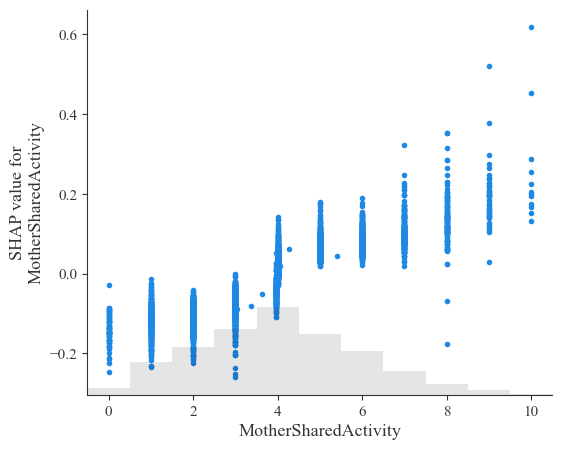

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherSharedActivity"])

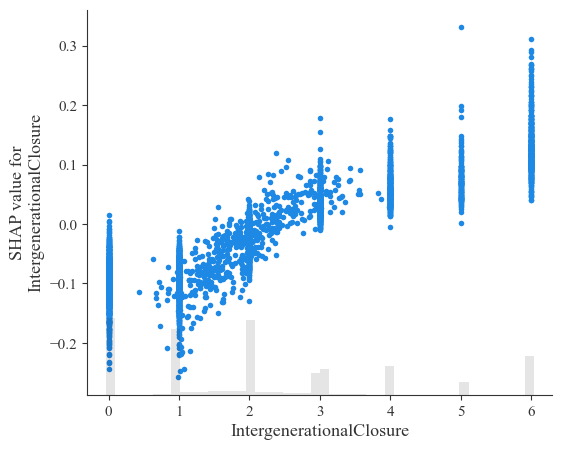

In [ ]:
shap.plots.scatter(shap_values_c[:,"IntergenerationalClosure"])

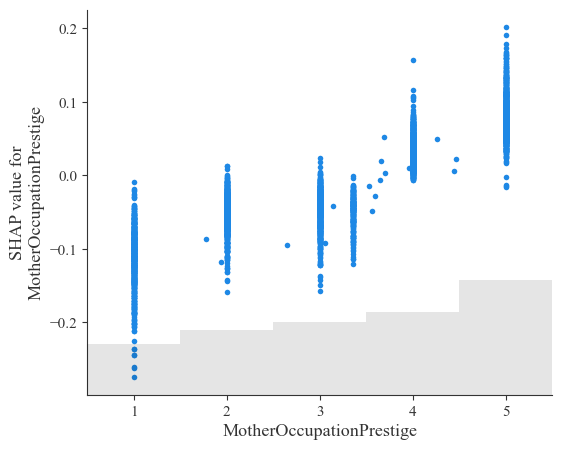

In [ ]:
shap.plots.scatter(shap_values_c[:,"MotherOccupationPrestige"])

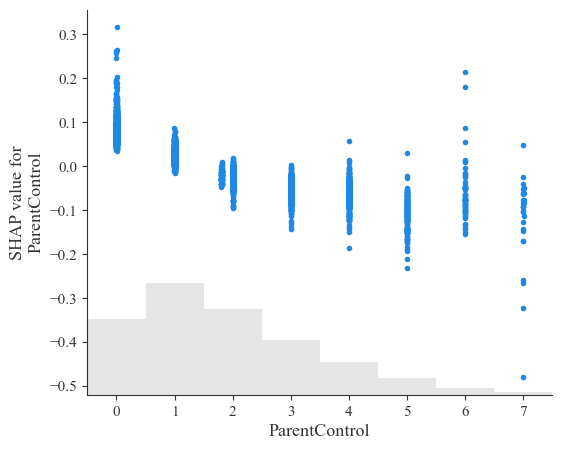

In [ ]:
shap.plots.scatter(shap_values_c[:,"ParentControl"])

### Make force plots

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[0], shap_values_c.values[0], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[0], shap_values_c.values[0], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot1.png')

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[1], shap_values_c.values[1], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[1], shap_values_c.values[1], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot2.png')

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[50], shap_values_c.values[50], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[50], shap_values_c.values[50], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot3.png')

In [ ]:
X_train.iloc[50]['IntergenerationalClosure']

0.0

In [ ]:
y_train.iloc[50]

14.0

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[100], shap_values_c.values[100], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[100], shap_values_c.values[100], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot4.png')

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[150], shap_values_c.values[150], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[150], shap_values_c.values[150], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot5.png')

In [ ]:
X_train.iloc[150]['EmotionalAbuse']

5.0

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[250], shap_values_c.values[250], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[250], shap_values_c.values[250], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot6.png')

In [ ]:
X_train.iloc[250]['Age']

13.0

In [ ]:
X_train.iloc[250]['MotherOccupationPrestige']

2.0

In [ ]:
shap.initjs()

#shap_train = explainer(X_train)
shap.plots.force(shap_values_c.base_values[300], shap_values_c.values[300], shap_values_c.feature_names)

In [ ]:
shap.plots.force(shap_values_c.base_values[300], shap_values_c.values[300], shap_values_c.feature_names,
                show=False,matplotlib=True).savefig('forceplot7.png')

In [ ]:
X_train.shape

(4091, 67)

### Interaction plots

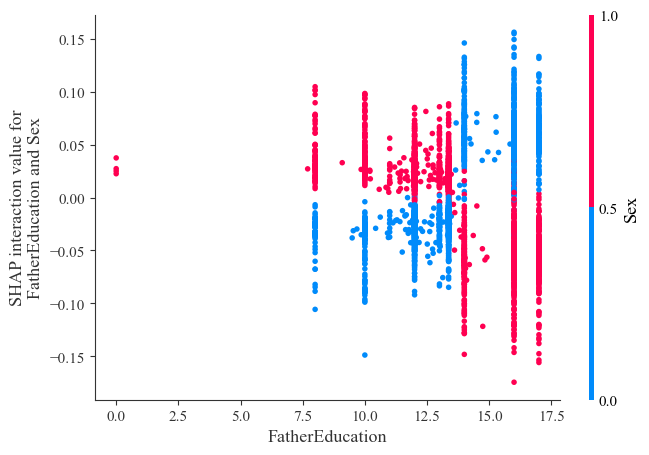

In [ ]:
shap.dependence_plot(
    ("FatherEducation", "Sex"),
    shap_interaction_values, X_train,
    display_features=X_train)

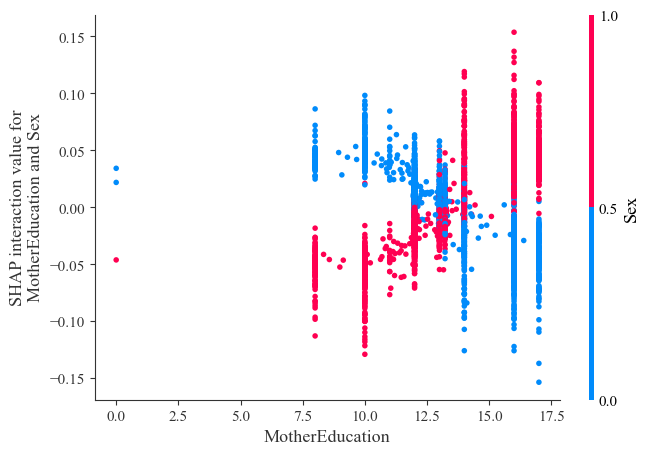

In [ ]:
shap.dependence_plot(
    ("MotherEducation", "Sex"),
    shap_interaction_values, X_train,
    display_features=X_train)

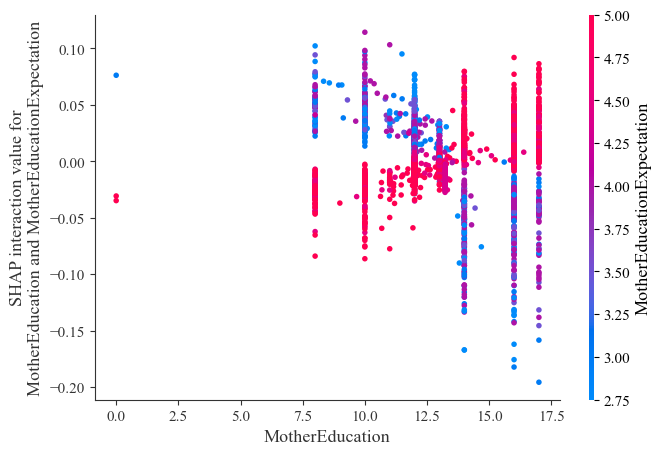

In [ ]:
shap.dependence_plot(
    ("MotherEducation", "MotherEducationExpectation"),
    shap_interaction_values, X_train,
    display_features=X_train)

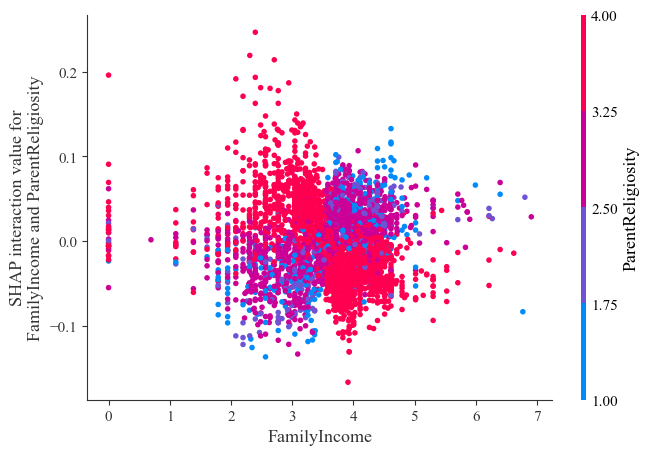

In [ ]:
shap.dependence_plot(
    ("FamilyIncome", "ParentReligiosity"),
    shap_interaction_values, X_train,
    display_features=X_train)

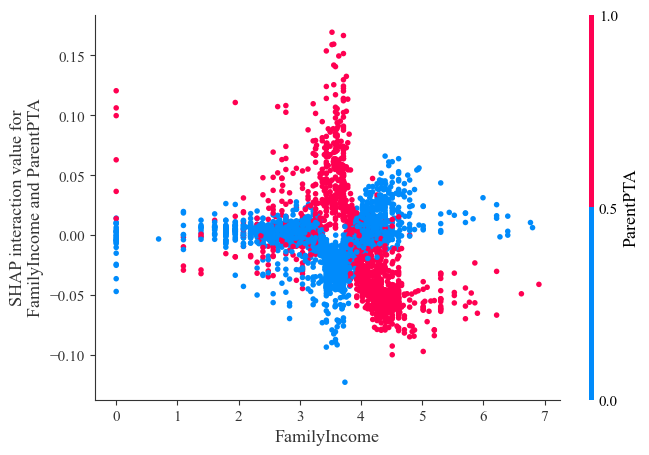

In [ ]:
shap.dependence_plot(
    ("FamilyIncome", "ParentPTA"),
    shap_interaction_values, X_train,
    display_features=X_train)

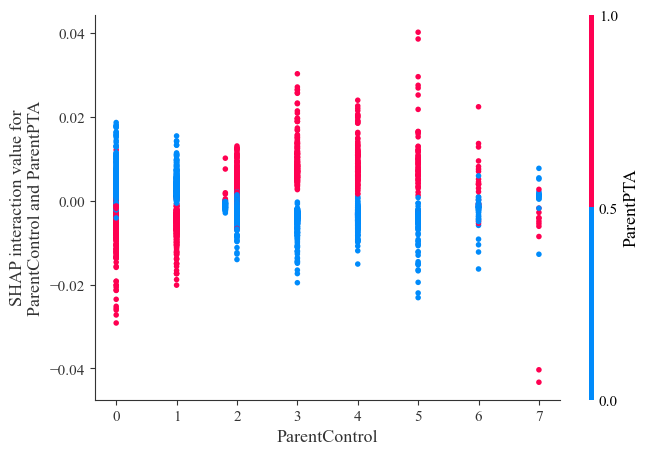

In [ ]:
shap.dependence_plot(
    ("ParentControl", "ParentPTA"),
    shap_interaction_values, X_train,
    display_features=X_train)

In [ ]:
shap.dependence_plot(
    ("FamilyIncome", "ParentReligiosity"),
    shap_interaction_values, X_train,
    display_features=X_train)